<font color=black size=5 face=雅黑>**EDA(Electrodermal Activity) processing pipeline Python**</font>

Created on 20201.7.10 by Rain. This notebook this for the physiological data processing of the VR Emotion project

The raw data we will use were obtained from BIOPAC MP160, and first exported in a mat format for segmentation.

Generally, I think the biosinal processing pipeline are basically the same for different kind of data, while the feature extraction can be different. 

In this script, the ECG analysis are mainly conducted by neurokit2, for preprocessing and feature extraction.
Overview:
Step 1: Dependcies and raw data import
Step 2: Extract the specific modality(if your data is multumodality) and downsampling accordingly
Step 3: Filter

## Step 1: Raw data import

In [1]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 9]  # Bigger images
plt.rcParams['font.size']= 13
data = loadmat('F:/1_Emotion_Data/Physiology/Helpless/sub_001_helpless_1.mat')

In [2]:
# Let's take a look of our current dataset
print(data);print(type(data));print(data.keys());

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Jun 21 13:57:21 2021', '__version__': '1.0', '__globals__': [], 'ecg_hl1': array([[0.07568359],
       [0.07614136],
       [0.0769043 ],
       ...,
       [0.04180908],
       [0.04226685],
       [0.04364014]]), 'eda_hl1': array([[11.65466267],
       [11.6592403 ],
       [11.65466267],
       ...,
       [11.64703327],
       [11.64703327],
       [11.64398151]]), 'emg_hl1': array([[ 0.00457764],
       [ 0.00030518],
       [-0.01846313],
       ...,
       [-0.00091553],
       [ 0.00045776],
       [ 0.00091553]]), 'emgc_hl1': array([[1.08489990e-04],
       [9.27734375e-05],
       [8.66699219e-05],
       ...,
       [4.30297852e-05],
       [3.71551514e-05],
       [3.39508057e-05]]), 'hr_hl1': array([[83.79888268],
       [83.79888268],
       [83.79888268],
       ...,
       [85.04606662],
       [85.04606662],
       [85.04606662]]), 'ppg_hl1': array([[-0.00091553],
       [-0.00091553],
       [-0.

## Primarily, we can see that within each mat file, the multimodality physiological data were stored into a numpy array individually

## Step 2: Flatten the data to one dimension and downsampling if needed

In [18]:
eda=data['eda_hl1'];eda.shape

(216001, 1)

In [19]:
eda=np.ndarray.flatten(eda);eda.shape ## For downsampling and further processing, we should flatten the 2-D array into a 1-D array

(216001,)

In [20]:
eda = nk.signal_resample(eda, method="numpy",sampling_rate=2000, desired_sampling_rate=300)# Here the neurokit downssampling functionwas used, in the manner of numpy downsampling

In [21]:
eda.shape

(32400,)

## Step 3: Clean the raw EDA signal

In [28]:
eda_cleaned=nk.eda_clean(eda,sampling_rate=300)

## Step 4: Computes autocorrelation measure of raw EDA signal (i.e., the correlation between the time series data and a specified time-lagged version of itself)

In [29]:
cor=nk.eda_autocor(eda_cleaned,sampling_rate=300);cor

0.9629655370864876

## Step 5: Calculate the number of change points using of the skin conductance signal in terms of mean and variance

In [30]:
change_points=nk.eda_changepoints(eda_cleaned);change_points

16175

## Step 5: Decompose the EDA signal into Tonic and Phasic components

In [31]:
components=nk.eda_phasic(eda_cleaned,sampling_rate=300,method='acqknowledge')

In [32]:
eda_phasic=components['EDA_Phasic'].values;eda_tonic=components['EDA_Tonic'].values

In [33]:
print(eda_phasic)
print(eda_tonic)

[-5.72418508e-04 -5.30463483e-04 -4.87500215e-04 ... -8.23044137e-06
 -7.28235525e-06 -6.28159788e-06]
[11.6555379  11.65553859 11.65553929 ... 11.6465502  11.6465502
 11.6465502 ]


## Step 6: Identify the Skin Conductance Rate (SCR) in EDA signal

In [34]:
scr_tup=nk.eda_peaks(eda_phasic,sampling_rate=300)

In [35]:
scr=scr_tup[0];scr

,SCR_Onsets,SCR_Peaks,SCR_Height,SCR_Amplitude,SCR_RiseTime,SCR_Recovery,SCR_RecoveryTime
0,0,0,0.0,0.0,0.0,0,0.0
1,0,0,0.0,0.0,0.0,0,0.0
2,0,0,0.0,0.0,0.0,0,0.0
3,0,0,0.0,0.0,0.0,0,0.0
4,0,0,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...
32395,0,0,0.0,0.0,0.0,0,0.0
32396,0,0,0.0,0.0,0.0,0,0.0
32397,0,0,0.0,0.0,0.0,0,0.0
32398,0,0,0.0,0.0,0.0,0,0.0


## Step 7: Aggregate the results and plot

In [36]:
eda_signals=pd.DataFrame({'EDA_Raw':eda,'EDA_Clean':eda_cleaned,'EDA_Tpnic':eda_tonic,'EDA_Phasic':eda_phasic})
eda_signals=pd.concat([eda_signals,scr],axis=1)

In [37]:
eda_signals

,EDA_Raw,EDA_Clean,EDA_Tpnic,EDA_Phasic,SCR_Onsets,SCR_Peaks,SCR_Height,SCR_Amplitude,SCR_RiseTime,SCR_Recovery,SCR_RecoveryTime
0,11.654663,11.654965,11.655538,-0.000572,0,0,0.0,0.0,0.0,0,0.0
1,11.653645,11.655008,11.655539,-0.000530,0,0,0.0,0.0,0.0,0,0.0
2,11.656189,11.655052,11.655539,-0.000488,0,0,0.0,0.0,0.0,0,0.0
3,11.654663,11.655096,11.655540,-0.000444,0,0,0.0,0.0,0.0,0,0.0
4,11.659240,11.655142,11.655541,-0.000399,0,0,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
32395,11.643981,11.645473,11.646550,-0.000010,0,0,0.0,0.0,0.0,0,0.0
32396,11.644999,11.645473,11.646550,-0.000009,0,0,0.0,0.0,0.0,0,0.0
32397,11.642456,11.645473,11.646550,-0.000008,0,0,0.0,0.0,0.0,0,0.0
32398,11.642456,11.645472,11.646550,-0.000007,0,0,0.0,0.0,0.0,0,0.0


ValueError: Length of values (196) does not match length of index (197)

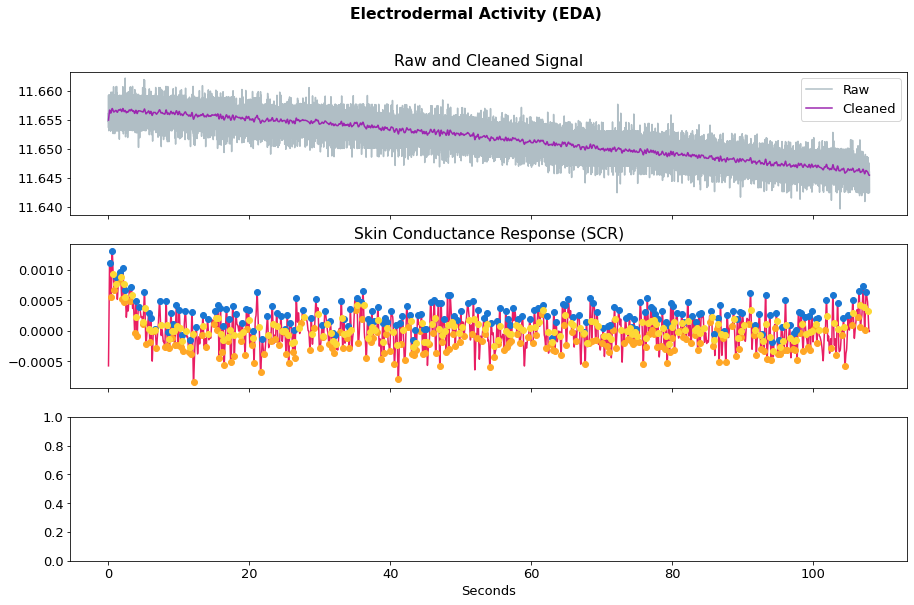

In [38]:
nk.eda_plot(eda_signals,sampling_rate=300)